<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S13_Time_Series_taxi_orders_in_next_hour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------
## Review

Hi, Doron! This is Daria again :) 

I changed the style of my comments, hope it makes them more readable :) Now you can find my comments in coloured blocks.

<font color='green'>I'm using green color if everything is done perfectly.</font>

<font color='blue'>Recommendations and remarks are highlighted in blue. </font>

<font color='red'>If the topic requires some extra work, the color will be red. </font>

<font color='green'>Thank you for your work! You handled this task really well, I see no critical flaws in your project :) You'll find some tips on how to improve your work below, but overall it is a great study. Keep it up!</font>

---------

## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

In [1]:
colab = True
if colab:
    data_path = 'https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/taxi.csv'
else:
    data_path = '/datasets/taxi.csv'

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

## Data download and Resampling (1H)

In [ ]:
data = pd.read_csv(data_path, index_col=[0],  parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

<font color='green'>Good, sum() is a correct function for aggregation in this case.</font>

# 2. Analysis

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
None


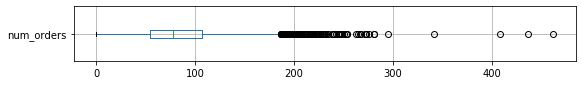

In [ ]:
print(data.head())
print(data.info())
data.boxplot(vert=False, figsize=(9,1));

As above, the data consists of hourly number of orders for the period 1/3/2018 to 31/8/2018. The majority number of orders is below 200 per hour, with few peaks above 300.

We will add `month`, `day`, `dayofweek`, `hour` as features in order to enhance the models. Note: no nead for year, since all data is in same year (2018)

In [ ]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

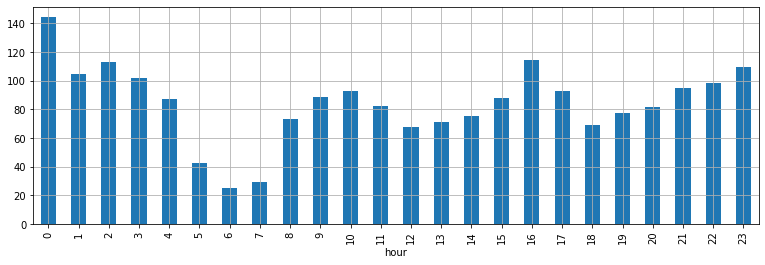

In [ ]:
data.groupby('hour')['num_orders'].mean().plot(kind='bar', grid=True, figsize=(13, 4));

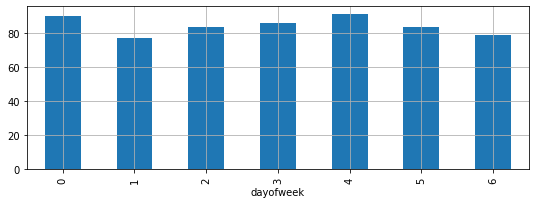

In [ ]:
data.groupby('dayofweek')['num_orders'].mean().plot(kind='bar', grid=True, figsize=(9, 3));

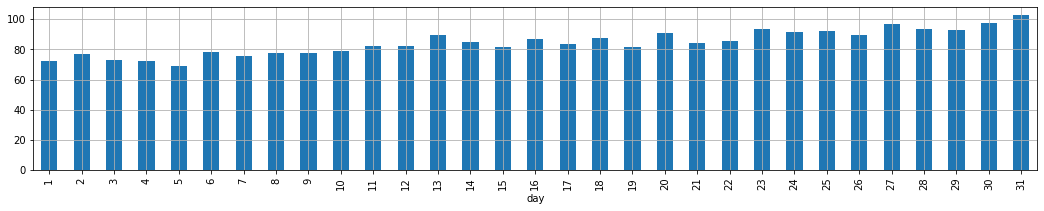

In [ ]:
data.groupby('day')['num_orders'].mean().plot(kind='bar', grid=True, figsize=(18, 3));

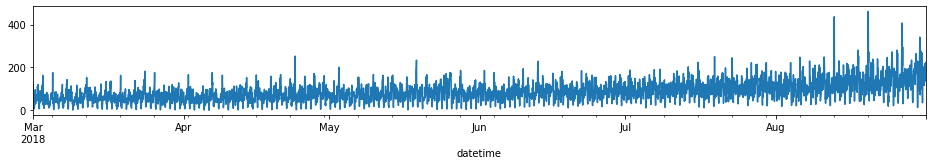

In [ ]:
data['num_orders'].plot(figsize=(16, 2));

## Analysis
In the above plots, we see the following:
- The hour has the biggest impact on the number of order.
- Not so much impact for day in week and day
- There is a steady growth over the entire period.
- There are high peaks in August

<font color='green'>So far so good :)</font>

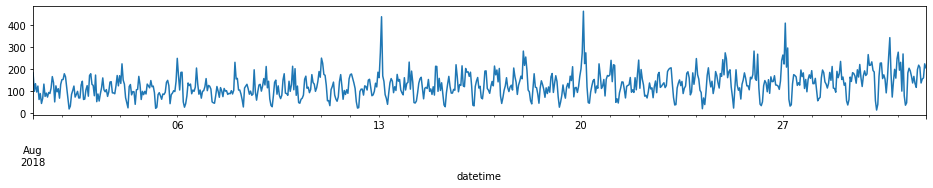

In [ ]:
data['2018-08-01':'2018-08-31']['num_orders'].plot(figsize=(16, 2));

The peaks occur in the last 3 weekends (00:00 - 01:00 on the nights between Sunday and Monday.

Let's proceed by deeper looking on last week of August:

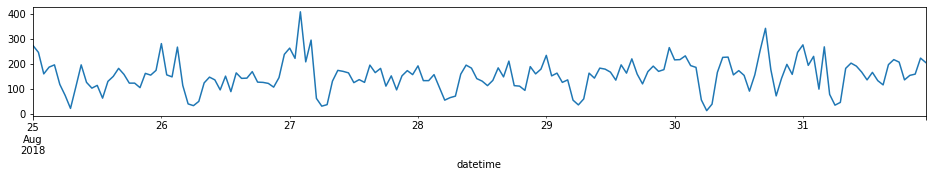

In [ ]:
data['2018-08-25':'2018-08-31']['num_orders'].plot(figsize=(16, 2));

We can notice that the daily low frequency occurs in early mornings (05:00 - 07:00), with high frequencies in the evenings and top frequencies in the night ending weekends, as already mentioned.

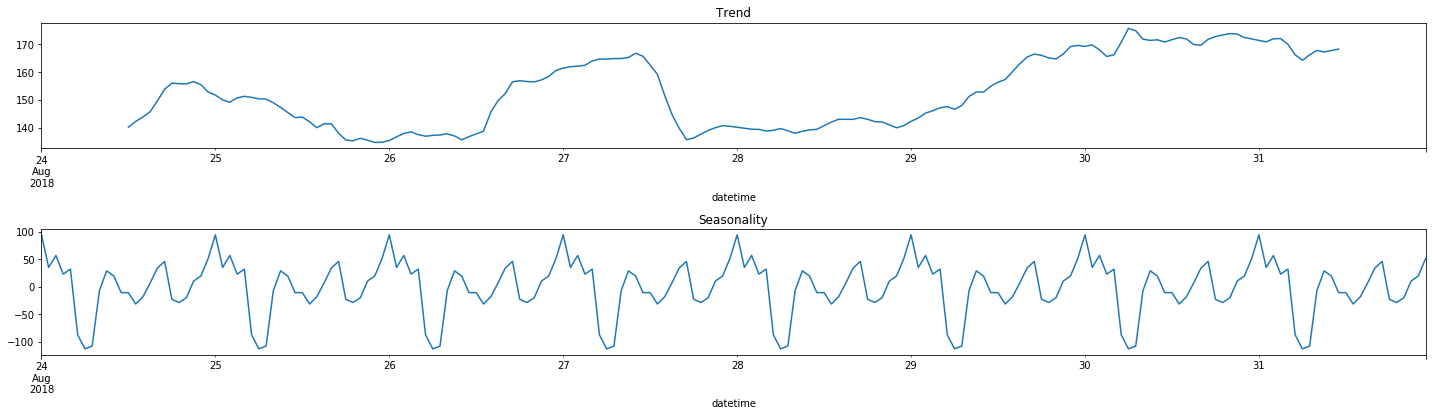

In [ ]:
decomposed = seasonal_decompose(data['2018-08-24':'2018-08-31']['num_orders'])
plt.figure(figsize=(20, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(),)
plt.title('Seasonality')
plt.tight_layout()

Same as stated before, is dispayed above using decomposition.

<font color='green'>You should use all the available data in seasonal_decompose() since there might be patterns, that are hard to determine within a small timeline. </font>

<font color='green'>We can see a clear daily seasonality - would be better to plot the seasonal component once again just for one day. A plot like that would be easier to analyze :) </font>

# 3. Training

In [ ]:
def prepare_sets(max_lag):
    df = data.copy()
    rolling_mean_size=5
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    train_valid, test = train_test_split(df, shuffle=False, test_size=0.1)
    train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

    train = train.dropna()

    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
    features_valid = valid.drop(['num_orders'], axis=1)
    target_valid = valid['num_orders'] 
    features_test = test.drop(['num_orders'], axis=1)
    target_test = test['num_orders'] 
    return features_train, target_train, features_valid, target_valid, features_test, target_test

def print_rmse():
    rmse_train = mean_squared_error(target_train, prediction_train) ** 0.5
    rmse_valid = mean_squared_error(target_valid, prediction_valid) ** 0.5
    print(f'RMSE Train: {rmse_train:,.0f}, Valid: {rmse_valid:,.0f}, diff(Train,Valid):{100*(rmse_valid - rmse_train)/rmse_train:,.1f}%')

## Linear Regression

In [ ]:
for max_lag in range(100, 130, 5):
    features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag)
    model = LinearRegression()
    model.fit(features_train, target_train)
    # model_name = model_type.__name__
    prediction_train = model.predict(features_train)
    prediction_valid = model.predict(features_valid)
    print(f'max_lag:{max_lag}')
    print_rmse()

max_lag:100
RMSE Train: 21, Valid: 30, diff(Train,Valid):41.8%
max_lag:105
RMSE Train: 21, Valid: 30, diff(Train,Valid):41.3%
max_lag:110
RMSE Train: 21, Valid: 30, diff(Train,Valid):41.5%
max_lag:115
RMSE Train: 21, Valid: 30, diff(Train,Valid):41.3%
max_lag:120
RMSE Train: 21, Valid: 29, diff(Train,Valid):41.7%
max_lag:125
RMSE Train: 21, Valid: 29, diff(Train,Valid):42.0%


<font color='green'>Great work on feature selection! Thank you for testing the effect of different lag sizes on the model's performance.</font>

<font color='green'>You choose pretty large lag sizes, would be interesting to compare results with the effect of smaller ones.
    
Also, it is a good practice to add a lag with the size of seasonality. E.g. when you see some daily(/weekly/monthly) patterns, you can add data from the previous day(/week/month), skipping the other hours.</font>

## Random Forest

In [ ]:
for max_depth_ in range(3,8):
    features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200)
    model = RandomForestRegressor(random_state=12345, max_depth=max_depth_)
    model.fit(features_train, target_train)
    prediction_train = model.predict(features_train)
    prediction_valid = model.predict(features_valid)
    print(f'max_depth={max_depth_}')
    print_rmse()

max_depth=3
RMSE Train: 21, Valid: 34, diff(Train,Valid):61.4%
max_depth=4
RMSE Train: 20, Valid: 32, diff(Train,Valid):61.2%
max_depth=5
RMSE Train: 19, Valid: 31, diff(Train,Valid):64.8%
max_depth=6
RMSE Train: 17, Valid: 31, diff(Train,Valid):76.1%
max_depth=7
RMSE Train: 16, Valid: 31, diff(Train,Valid):92.2%


As above, Random Forest is doing less great than Linear Regression

<font color='green'>True :) It's actually better on train, but its generalization seems to be worse.</font>

<font color='green'>A small tip: for a better model validation you can use cross-validation, i.e. split your data on train&valid datasets multiple times. Since we are working with time series data and, therefore, have to split our data linearly, we can use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">TimeSeriesSplit</a> from sklearn.model_selection. You can read more about cross-validation <a href="https://scikit-learn.org/stable/modules/cross_validation.html">here</a>.
</font>

## Light GBM

In [ ]:
for nleaves_ in range(3,6):
    features_train, target_train, features_valid, target_valid, features_test, target_test = prepare_sets(max_lag=200)
    nleaves = nleaves_
    params = {
        'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'root_mean_squared_error'}, 'num_leaves': nleaves,
        'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0}
    lgb_train = lgbm.Dataset(features_train, target_train)
    lgb_valid = lgbm.Dataset(features_valid, target_valid, reference=lgb_train)
    print(f'nleaves={nleaves_}')
    gbm = lgbm.train(params,
                    lgb_train,
                    num_boost_round=800,
                    valid_sets=lgb_valid,
                    early_stopping_rounds=5,verbose_eval=100)
    prediction_train = gbm.predict(features_train, num_iteration=gbm.best_iteration)
    prediction_valid = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
    print_rmse()

nleaves=3
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 31.0512
Early stopping, best iteration is:
[181]	valid_0's rmse: 29.4086
RMSE Train: 19, Valid: 29, diff(Train,Valid):56.3%
nleaves=4
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 29.9318
Early stopping, best iteration is:
[140]	valid_0's rmse: 29.1245
RMSE Train: 18, Valid: 29, diff(Train,Valid):57.7%
nleaves=5
Training until validation scores don't improve for 5 rounds
[100]	valid_0's rmse: 29.9217
Early stopping, best iteration is:
[100]	valid_0's rmse: 29.9217
RMSE Train: 19, Valid: 30, diff(Train,Valid):61.6%


As above, Light GBM also not championning: although similar RMSE to Linear Regression, there is much mode overfit..

# 4. Testing

As above, we decided on Linear regression with max_lah=115

In [ ]:
max_lag = 115
df = data.copy()
rolling_mean_size=5
for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders'] 

model = LinearRegression()
model.fit(features_train, target_train)

prediction_train = model.predict(features_train)
prediction_test = model.predict(features_test)

rmse_train = mean_squared_error(target_train, prediction_train) ** 0.5
rmse_test = mean_squared_error(target_test, prediction_test) ** 0.5
print(f'RMSE Train: {rmse_train:,.0f}, Test: {rmse_test:,.0f}')

RMSE Train: 22, Test: 41


<font color='green'>Glad that you didn't forget to use the merged train+valid dataset to train the final model :) Your score is super-low, nice job!</font>

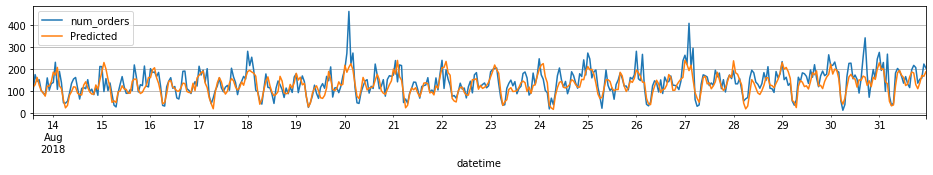

In [ ]:
Glad that you didn't forget to use the merged train+valid dataset to train the final model :) Your score is super-low, nice job!df = pd.DataFrame(target_test)
df['Predicted'] = pd.Series(model.predict(features_test),index=target_test.index)
df.plot(figsize=(16, 2),grid=True);

Conclusion: the Linear Regression give us overall quite good results. There can be still room for improvement on the peaks.

<font color='green'>Good one! Visualization of model's predictions helped us to understand the nature of the errors :)</font>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48